# Comparison of the HSC deblender and scarlet

In this demo we look at three different blends using both the HSC deblender and scarlet to deblend them:

1. A blend that both the HSC deblender and scarlet deblend well
2. A blend that the HSC deblender struggles with but scarlet is successful
3. A blend that scarlet shows improved performance over the HSC deblender but still struggles with

In [1]:
# Imports

import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization.lupton_rgb import AsinhMapping
from astropy.visualization import ZScaleInterval
import scarlet
import scarlet.display

from lsst.daf.persistence import Butler
from lsst.afw.table import SourceCatalog
from lsst.afw.image import MultibandExposure
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendConfig, SourceDeblendTask
import lsst.meas.extensions.scarlet as mes

In [2]:
# Load the data in each band
butler = Butler("/datasets/hsc/repo/rerun/RC/w_2019_26/DM-19560/")
dataId = {"tract": 9813, "patch": "4,4"}
filters = "grizy"
coadds = []
for f in filters:
    coadds.append(butler.get("deepCoadd_calexp", dataId, filter="HSC-{}".format(f.upper())))
coadds = MultibandExposure.fromExposures(filters, coadds)

In [3]:
# Run detection on the "r" band image
# In reality this should be done in all bands and then have the
# results merged, but for the sake of this tutorial it is faster/easier
# to just run detection on a single image.

schema = SourceCatalog.Table.makeMinimalSchema()
detectionTask = SourceDetectionTask(schema=schema)
deblendTask = SourceDeblendTask(schema=schema)
table = SourceCatalog.Table.make(schema)
detectionResult = detectionTask.run(table, coadds["r"])
catalog = detectionResult.sources

In [4]:
# Choose the subset of the catalog that contains the three blends of interest

#parents = [9810, 5245, 7715, 566, 4432, 5867, 10740, 2911, 5003, 5867, 13051]
parents = [2520, 3621, 9810]
indices = np.zeros((len(catalog),), dtype=bool)
for pidx in parents:
    indices = indices | (catalog["id"] == pidx)
subset = catalog[indices]

In [5]:
# Run the old deblender on the subset of blends and store each catalog in a dictionary
catalogs = {}
for f in filters:
    _catalog = SourceCatalog(catalog.table.clone())
    _catalog.extend(subset, deep=True)
    catalogs[f] = _catalog
    deblendTask.run(coadds[f], catalogs[f])

In [6]:
from lsst.geom import Box2I, Point2I
import lsst.afw.image as afwImage


def get_old_heavy_image(catalogs, idx):
    """Load the multiband image data cube for a given source in a blend
    """
    footprints = [catalogs[f][idx].getFootprint() for f in catalogs]
    # Since the HSC deblender works separately on each band, we need to
    # make an image that fits all of the footprints inside and properly
    # project them into the result
    xmin = np.min([fp.getBBox().getMinX() for fp in footprints])
    ymin = np.min([fp.getBBox().getMinY() for fp in footprints])
    xmax = np.max([fp.getBBox().getMaxX() for fp in footprints])
    ymax = np.max([fp.getBBox().getMaxY() for fp in footprints])
    bbox = Box2I(Point2I(xmin, ymin), Point2I(xmax, ymax))
    result = np.zeros((len(catalogs), bbox.getHeight(), bbox.getWidth()))
    for b, fp in enumerate(footprints):
        _img = afwImage.Image(bbox, dtype=np.float32)
        fp.insert(_img)
        result[b] += _img.array
    return result, bbox

def run_scarlet(coadds, catalog, parentId):
    """Execute scarlet on a given blend
    """
    parent = catalog[catalog["id"] == parentId][0]
    foot = parent.getFootprint()
    config = mes.ScarletDeblendConfig()
    config.maxIter = 200
    config.relativeError = 1e-3
    blend = mes.deblend(coadds, foot, None, config)
    return blend

def display_results(coadds, catalogs, blend, parentId, rescale=True, scale_factor=5):
    """Display the results using the HSC deblender and scarlet side by side
    """
    # Define the color scaling
    asinh = AsinhMapping(minimum=0, stretch=1, Q=10)
    
    parent = catalogs["r"][catalogs["r"]["id"] == parentId][0]
    bbox = parent.getFootprint().getBBox()
    image = coadds[:, bbox].image.array
    img_rgb = scarlet.display.img_to_rgb(image[:3], norm=asinh)
    fig = plt.figure(figsize=(15, 8))
    plt.imshow(img_rgb)
    plt.title("Blend number {0}".format(parentId))
    for k, peak in enumerate(parent.getFootprint().getPeaks()):
        px, py = peak.getIx(), peak.getIy()
        px = px - bbox.getMinX()
        py = py - bbox.getMinY()
        plt.text(px, py, str(k), color="cyan")
    plt.show()

    childrenIdx = np.where(catalogs["r"]["parent"] == parentId)[0]
    for k, cidx in enumerate(childrenIdx):
        # Extract the source model from the hsc deblender
        hsc_model, hsc_bbox = get_old_heavy_image(catalogs, int(cidx))
        
        if rescale:
            asinh = AsinhMapping(minimum=0, stretch=hsc_model.max()/scale_factor, Q=10)
        
        hsc_rgb = scarlet.display.img_to_rgb(hsc_model[:3], norm=asinh)
        # Extract the source model from scarlet, convolved with the observed PSFs
        scarlet_model = blend.observations[0].render(blend.sources[k].get_model())
        
        # Project the original image and scarlet model onto the same bbox as the HSC model
        xmin, ymin = hsc_bbox.getMin()
        xmin -= bbox.getMinX()
        ymin -= bbox.getMinY()
        width, height = hsc_bbox.getDimensions()
        if xmin < 0:
            width += xmin
            xmin = 0
        if ymin < 0:
            height += ymin
            ymin = 0
        slices = (slice(None, 3), slice(ymin, ymin+height), slice(xmin, xmin+width))
        
        scarlet_rgb = scarlet.display.img_to_rgb(scarlet_model[slices], norm=asinh)
        img_rgb = scarlet.display.img_to_rgb(image[slices], norm=asinh)
        
        fig = plt.figure(figsize=(15, 8))
        ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
        ax[0].imshow(img_rgb)
        ax[0].set_title("Data")
        peak = parent.getFootprint().getPeaks()[k]
        px, py = peak.getIx(), peak.getIy()
        px = px - hsc_bbox.getMinX()
        py = py - hsc_bbox.getMinY()
        ax[0].plot(px, py, "cx", mew=2)
        ax[1].imshow(hsc_rgb)
        ax[1].set_title("HSC {0}".format(k))
        ax[2].imshow(scarlet_rgb)
        ax[2].set_title("scarlet {0}".format(k))
        plt.show()

# A Well Deblended Scene

We first look at a blend that both deblenders are able to deblend. This is a fairly typical blend in that there are a number of sources in the `Footprint`, some of which are more isolated while others are blended more closely. This illustrates the success of using monotonicity and symmetry in order to deblend a scene.

In [7]:
parentId = 2520
blend = run_scarlet(coadds, catalog, parentId)

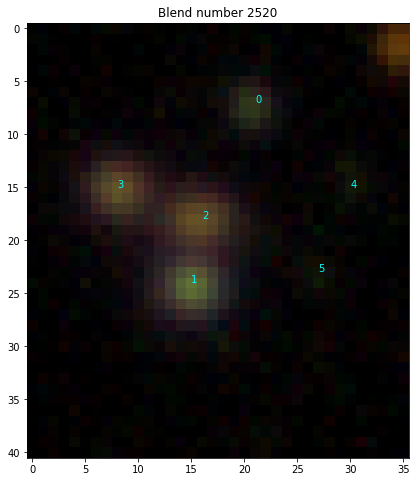

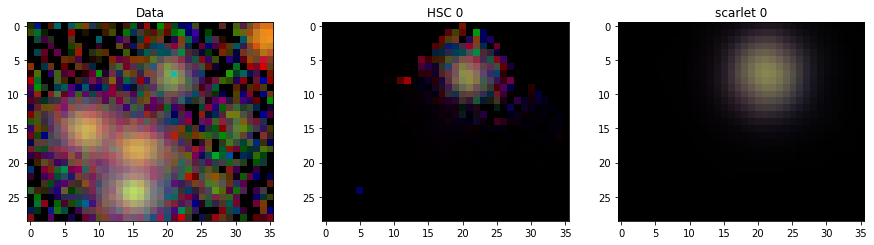

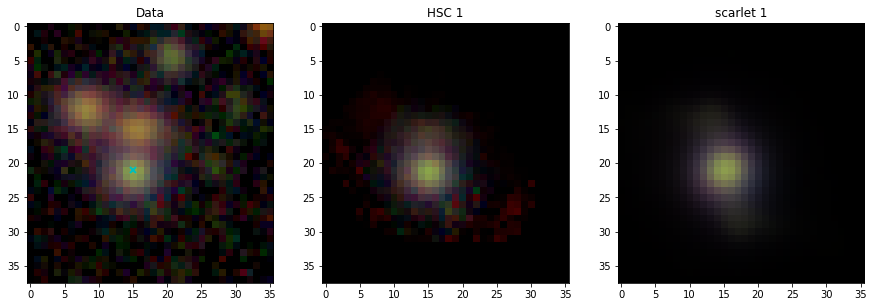

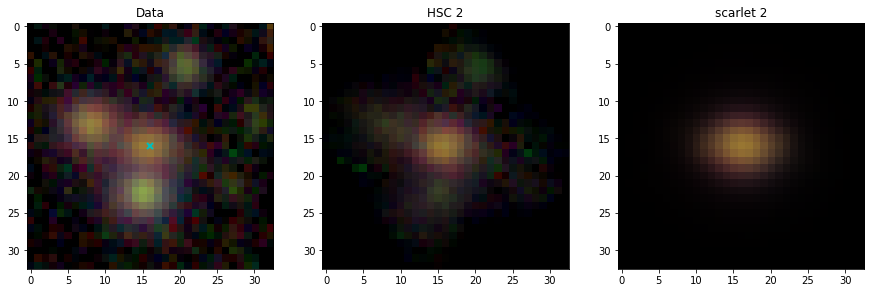

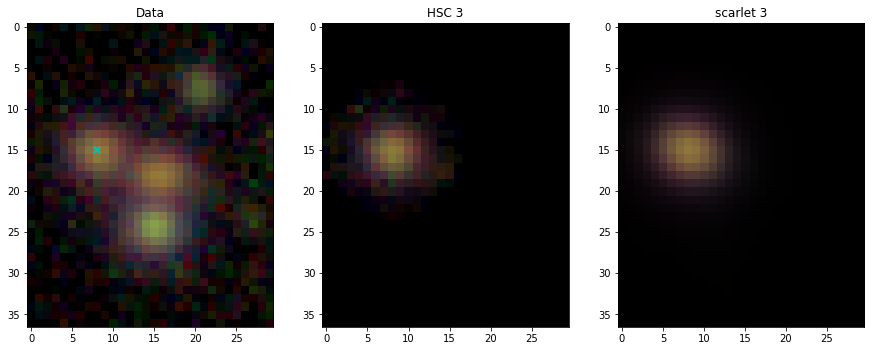

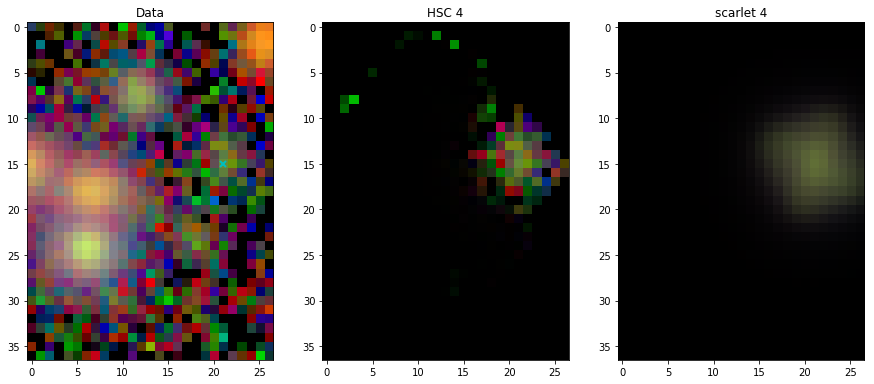

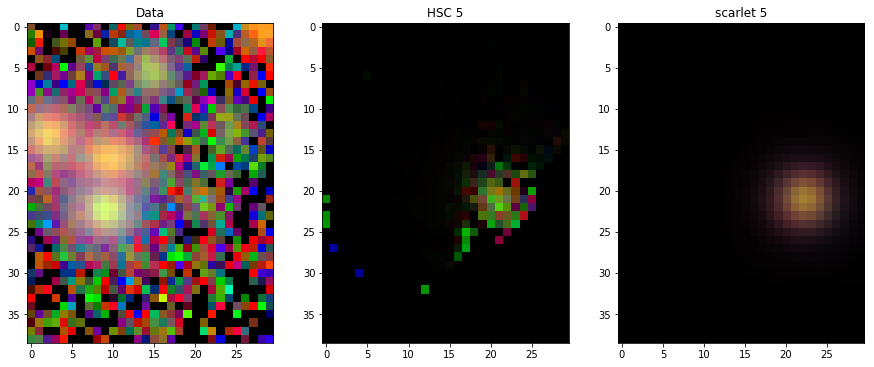

In [8]:
display_results(coadds, catalogs, blend, parentId)

# A More Difficult Blend

This is a more challenging blend. What makes this blend difficult for the HSC deblender is that many of the sources have neighbors on opposite sides of the peak, meaning symmetry is no longer strong enough to constraint their flux. By using multiband information and an iterative deblending procedure scarlet is able to successfully deblend scenes like this where the old HSC deblender fails.

In [9]:
parentId = 3621
blend2 = run_scarlet(coadds, catalog, parentId)

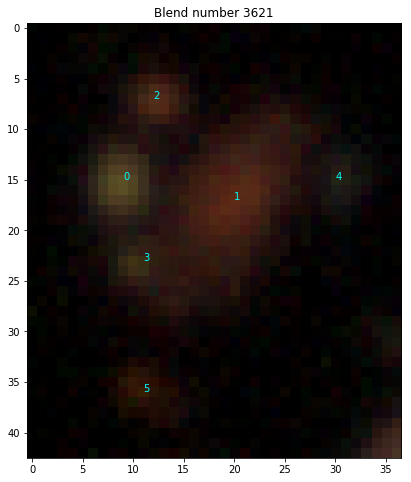

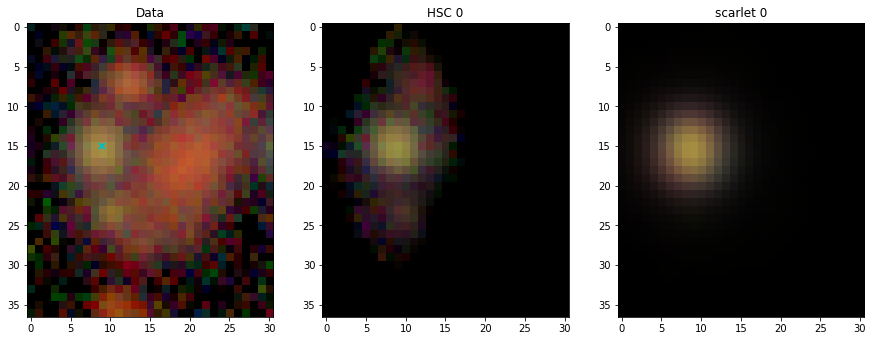

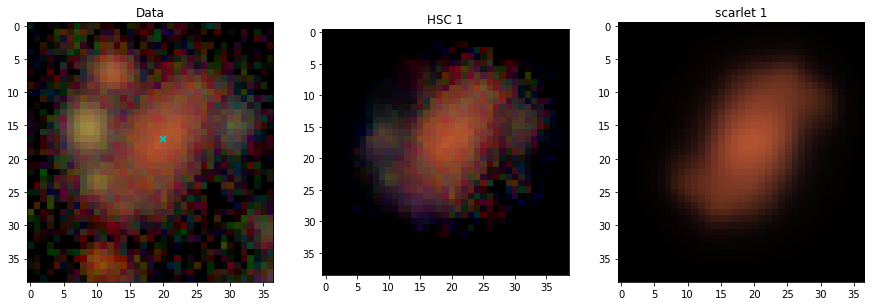

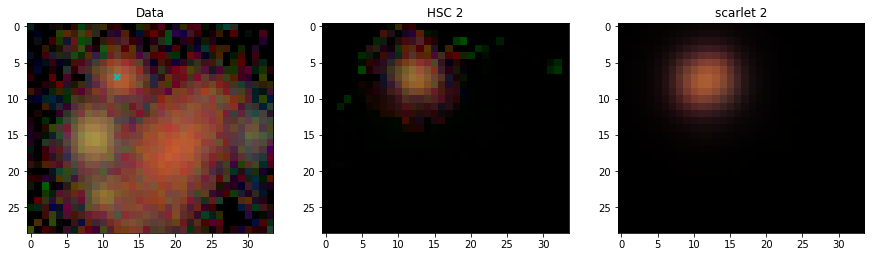

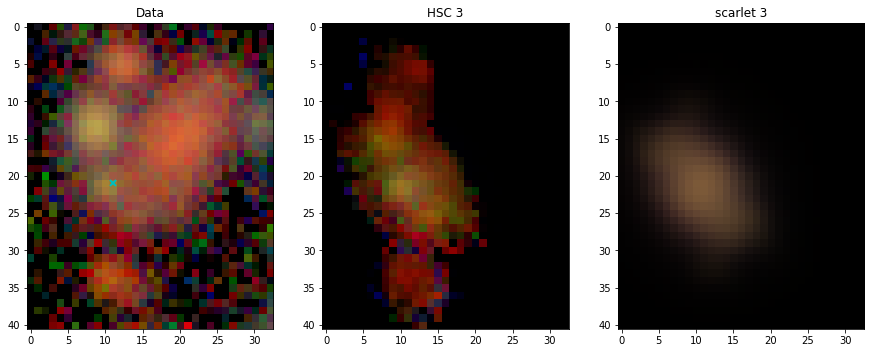

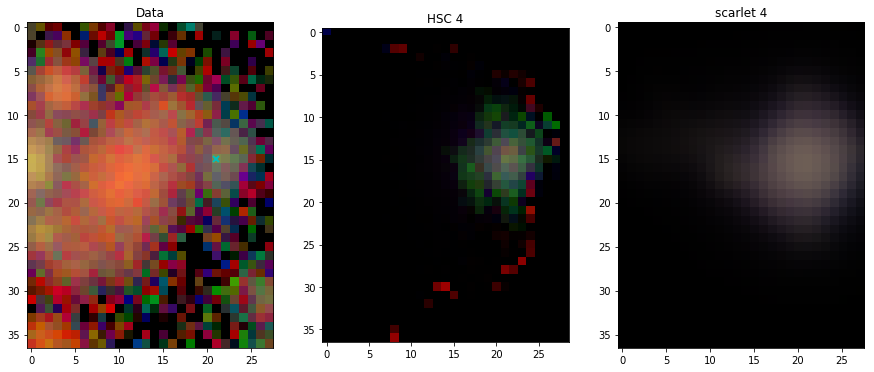

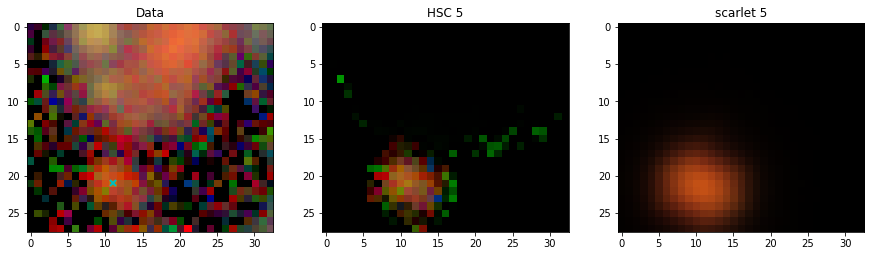

In [18]:
display_results(coadds, catalogs, blend2, parentId)

# The Most Difficult Blend

This scene can be thought of as the true test of a deblender. Not only are there 3 bright sources in a row, one of them is a resolved spiral that has asymmetric structures. The HSC deblender struggles due to the three in a row problem that it will always face (see peaks 3, 4, and 5 below).

scarlet struggles for now because there is still a bug in determining the center of a source, so the fractional pixel offset from each source poses problems for the symmetry algorithm for the central object. However symmetry is too strict for the spiral (peak 3), which is not symmetric, so scarlet also fails to model that source. But there is still significant improvement for peaks 4 and 5, with a version of scarlet in development that produces a much better model for peak 5.

In [11]:
parentId = 9810
blend3 = run_scarlet(coadds, catalog, parentId)

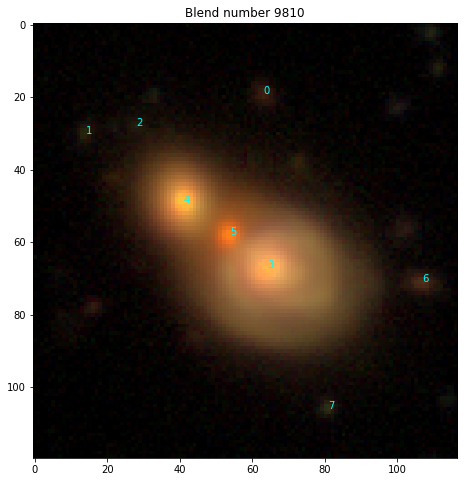

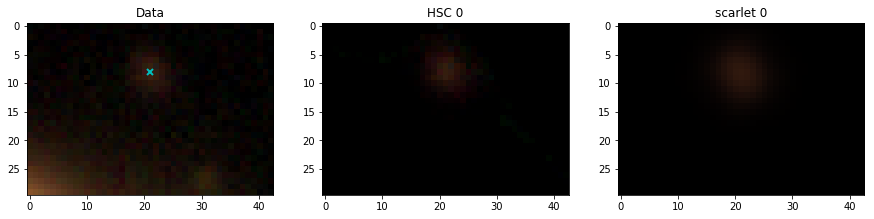

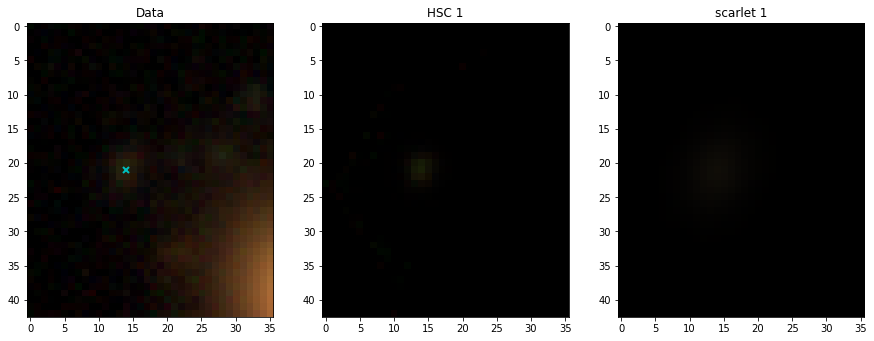

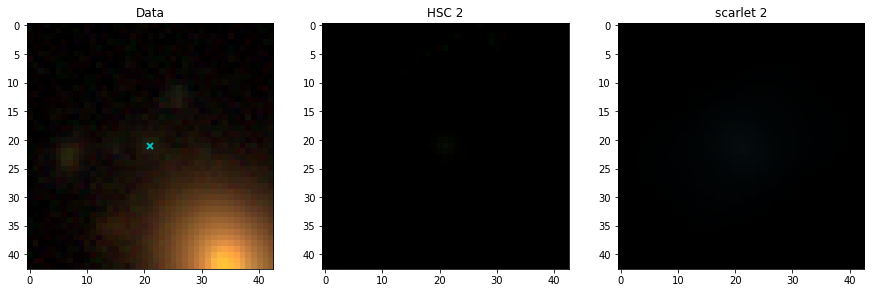

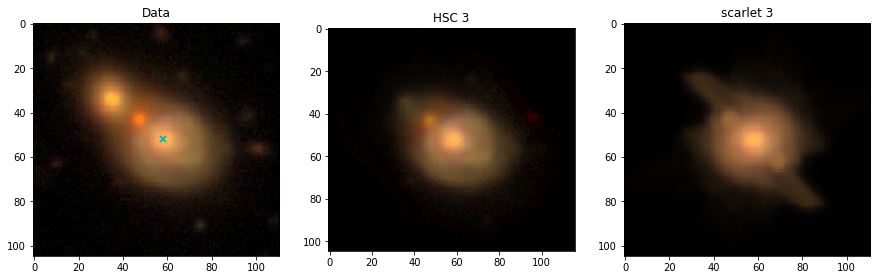

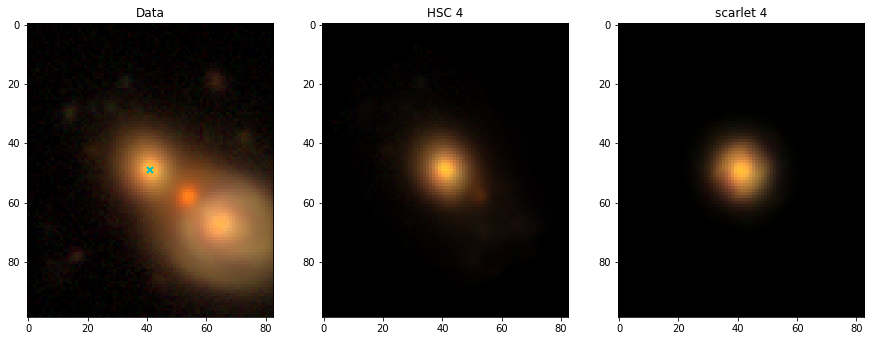

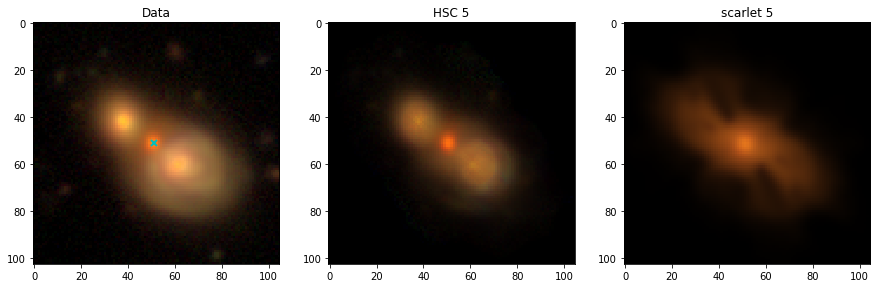

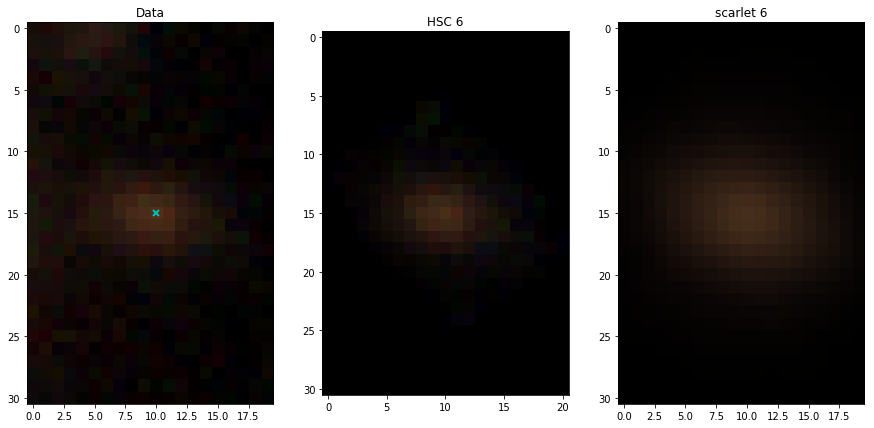

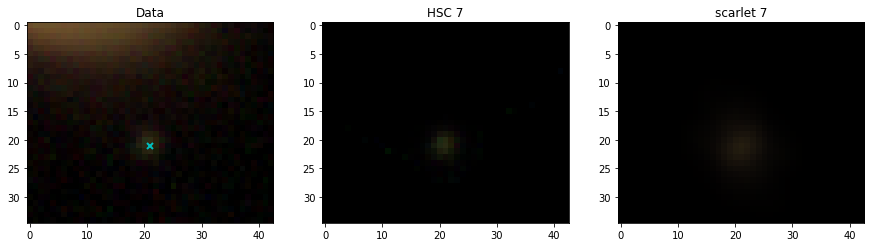

In [12]:
display_results(coadds, catalogs, blend3, 9810, False)